In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score

from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
#import warnings

In [2]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# read phenotype features file for trial 1 cannabises
plant_xls = pd.read_csv('filtered_name.csv')
plant_xls.head()

Unnamed: 0          SPECIES     COMNM MATNM  LCCD  PLTID TRLID BLOCK COL  \
0           0  Cannabis sativa  Cannabis  Kush  NZPN      1   CB1     A   A   
1           2  Cannabis sativa  Cannabis  Kush  NZPN      3   CB1     A   A   
2           4  Cannabis sativa  Cannabis  Kush  NZPN      5   CB1     A   B   
3           6  Cannabis sativa  Cannabis  Kush  NZPN      7   CB1     A   B   
4           7  Cannabis sativa  Cannabis  Kush  NZPN      8   CB1     A   B   

   ROW  ... DANT.L9_49 DNBI.L9_49 DCHL.L10_49  DFLA.L10_49  DANT.L10_49  \
0    1  ...      0.156      24.45         NaN          NaN          NaN   
1    3  ...      0.154      21.22      36.376        2.094        0.184   
2    1  ...      0.186      16.00         NaN          NaN          NaN   
3    3  ...      0.125      18.85      35.393        2.138        0.132   
4    4  ...      0.165      17.04      32.485        2.130        0.201   

   DNBI.L10_49  DCHL.L11_49  DFLA.L11_49  DANT.L11_49  DNBI.L11_49  
0          NaN          NaN          NaN          NaN          NaN  
1        17.37          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN          NaN  
3        16.56          NaN          NaN          NaN          NaN  
4        15.25          NaN          NaN          NaN          NaN  

[5 rows x 192 columns]

In [4]:
# filter kush and angel cultivate
Kush_xls = plant_xls[(plant_xls['MATNM'] == 'Kush')]
Angel_xls = plant_xls[(plant_xls['MATNM'] == 'Angel')]

In [5]:
# Remove null feature columns from angel and kyush
null_cols_angel = Angel_xls.columns[Angel_xls.isnull().any()]
Angel_xls.drop(null_cols_angel, axis=1, inplace=True)

null_cols_kush = Kush_xls.columns[Kush_xls.isnull().any()]
Kush_xls.drop(null_cols_kush, axis=1, inplace=True)

c:\users\asingh1\pycharmprojects\biolumic\venv\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
# remove those columns which are not feature from the angel_xls and kush_xls
Angel_xls1 = Angel_xls.iloc[:, 15:]
Kush_xls1 = Kush_xls.iloc[:, 15:]

In [7]:
# Use common feature set between angel and kush for data exploration.
#new_kush = Kush_xls1.loc[:, Angel_xls1.columns.intersection(Kush_xls1.columns)]

In [8]:
Kush_xls1.columns

Index(['FWFR_91', 'INL_21', 'INL_14', 'DCHL.L1_14', 'DFLA.L1_14', 'DANT.L1_14',
       'DNBI.L1_14', 'PLTHGT_7', 'PLTHGT_14', 'PLTHGT_21', 'PLTHGT_28',
       'PLTHGT_35', 'PLTHGT_42', 'PLTHGT_49', 'PLTHGT_56', 'PLTVOL_56',
       'PLTHGT_70', 'PLTVOL_70', 'PLTHGT_77', 'PLTVOL_77', 'INL_28', 'INL_35',
       'INL_42', 'ILA_14', 'DCHL.L1_21', 'DCHL.L2_21', 'DCHL.L3_21',
       'DFLA.L1_21', 'DFLA.L2_21', 'DFLA.L3_21', 'DANT.L1_21', 'DANT.L2_21',
       'DANT.L3_21', 'DCHL.L1_28', 'DCHL.L2_28', 'DCHL.L3_28', 'DCHL.L4_28',
       'DCHL.L5_28', 'DFLA.L1_28', 'DFLA.L2_28', 'DFLA.L3_28', 'DFLA.L4_28',
       'DFLA.L5_28', 'DANT.L1_28', 'DANT.L2_28', 'DANT.L3_28', 'DANT.L4_28',
       'DANT.L5_28'],
      dtype='object')

In [9]:
#new_kush = Kush_xls1.loc[:,['FWFR_91', 'DCHL.L2_28', 'DCHL.L3_28', 'DCHL.L4_28']]

new_kush =  Kush_xls1.loc[:,['FWFR_91', 'INL_21','DANT.L1_14', 'DCHL.L1_14', 'PLTHGT_7', 'PLTHGT_14']]


In [10]:
new_kush.head()#4, 5, 16, 31, 32

FWFR_91    INL_21  DANT.L1_14  DCHL.L1_14  PLTHGT_7  PLTHGT_14
0   10.605  0.769231       0.134      28.941       2.8        4.5
1   13.974  0.666667       0.147      27.385       3.2        4.2
2   11.400  0.533333       0.117      32.379       4.2        6.0
3    8.843  0.545455       0.143      32.837       3.0        5.0
4    8.687  0.615385       0.123      30.535       3.4        5.0

In [11]:
# extract features and measured FFW from new_angel
X_df = new_kush.iloc[:, 1:]
y_df = new_kush.iloc[:, 0]
print(y_df[:5])
print(X_df.head())

0    10.605
1    13.974
2    11.400
3     8.843
4     8.687
Name: FWFR_91, dtype: float64
     INL_21  DANT.L1_14  DCHL.L1_14  PLTHGT_7  PLTHGT_14
0  0.769231       0.134      28.941       2.8        4.5
1  0.666667       0.147      27.385       3.2        4.2
2  0.533333       0.117      32.379       4.2        6.0
3  0.545455       0.143      32.837       3.0        5.0
4  0.615385       0.123      30.535       3.4        5.0


In [12]:
X_df.head()

INL_21  DANT.L1_14  DCHL.L1_14  PLTHGT_7  PLTHGT_14
0  0.769231       0.134      28.941       2.8        4.5
1  0.666667       0.147      27.385       3.2        4.2
2  0.533333       0.117      32.379       4.2        6.0
3  0.545455       0.143      32.837       3.0        5.0
4  0.615385       0.123      30.535       3.4        5.0

In [13]:

svr_lin1 = SVR(kernel='linear',C=1.0, gamma= 'scale')
svr_lin2 = SVR(kernel='linear',C=2.0, gamma= 'scale')
svr_lin3 = SVR(kernel='linear',C=3.0, gamma= 'scale')
svr_lin4 = SVR(kernel='linear',C=4.0, gamma= 'scale')
svr_lin6 = SVR(kernel='linear',C=10.0, gamma='scale')



#Meta regressor
svr_rbf = SVR(kernel='rbf',C=10.0, gamma= 0.1)


regressors = [svr_lin1,svr_lin2,
              svr_lin3,svr_lin4,
              svr_lin6]
#svr_lin5,
stregr = StackingRegressor(regressors=regressors, 
                            meta_regressor=svr_rbf)


In [14]:
# below is leave one out cross validation (loocv)

loo = LeaveOneOut()
prediction_y = []  # list to hold prediction from loocv
true_y = []  # list to hold true values
for train_index, test_index in loo.split(X_df, y_df):
    #print("TEST:", test_index)
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index].values, y_df.iloc[test_index].values

    # fit stacked regression on training set
    stregr.fit(X_train.values, y_train)

    # predict output and append in list
    y_pred = stregr.predict(X_test.values)
    prediction_y.append(y_pred)
    true_y.append(y_test)

np_prediction_y = np.vstack(prediction_y)
np_true_y = np.vstack(true_y)

# get r2 and mse from predicted and true values
r2_score_loocv = r2_score(np_true_y, np_prediction_y)
mse_loocv = mean_squared_error(np_true_y, np_prediction_y)
print(r2_score_loocv)
print(mse_loocv)

0.01634823353267012
18.102823707859834


In [15]:
# RMSE for each treatment
pl_bc1 = sqrt(mean_squared_error(np_prediction_y[0:14], np_true_y[0:14]))
print(pl_bc1)
pl_bc2 = sqrt(mean_squared_error(np_prediction_y[14:30], np_true_y[14:30]))
print(pl_bc2)
pl_control = sqrt(mean_squared_error(np_prediction_y[30:], np_true_y[30:]))
print(pl_control)


4.173846098560829
4.260140563488491
4.328061291917726


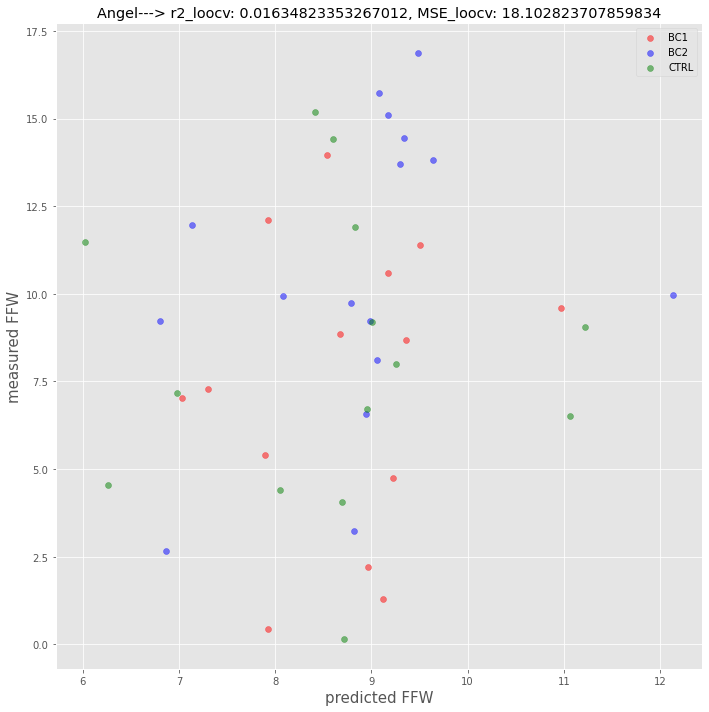

In [16]:
# plot predicted and true FFW values
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(np_prediction_y[:14], np_true_y[:14], c='red', alpha=0.5, label='BC1')
    ax.scatter(np_prediction_y[14:30], np_true_y[14:30], c='blue', alpha=0.5, label='BC2')
    ax.scatter(np_prediction_y[30:], np_true_y[30:], c='green', alpha=0.5, label='CTRL')
    ax.set_xlabel('predicted FFW', fontsize=15)
    ax.set_ylabel('measured FFW', fontsize=15)
    ax.set_title('Angel---> r2_loocv: ' + str(r2_score_loocv) + ', MSE_loocv: ' + str(mse_loocv))
    ax.legend()
ax.grid(True)
fig.tight_layout()

plt.show()

In [17]:
# test with random noise matrix

svr_lin1 = SVR(kernel='linear',C=1.0, gamma= 'scale')
svr_lin2 = SVR(kernel='linear',C=2.0, gamma= 'scale')
svr_lin3 = SVR(kernel='linear',C=3.0, gamma= 'scale')
svr_lin4 = SVR(kernel='linear',C=4.0, gamma= 'scale')
svr_lin6 = SVR(kernel='linear',C=10.0, gamma='scale')



#Meta regressor
svr_rbf = SVR(kernel='rbf',C=10.0, gamma= 0.1)


regressors = [svr_lin1,svr_lin2,
              svr_lin3,svr_lin4,
              svr_lin6]
#svr_lin5,
stregr1 = StackingRegressor(regressors=regressors, 
                            meta_regressor=svr_rbf)

Xrand = np.random.rand(44,5)

# Below we use random number matrix as features to predict FFW with respect to true FFW using Loocv techniquw
loo = LeaveOneOut()
predi_y = []  # list to hold prediction from loocv
all_y = []  # list to hold true values from loocv
for train_index, test_index in loo.split(Xrand, y_df):
    # print("TEST:", test_index)
    X_train, X_test = Xrand[train_index], Xrand[test_index]
    y_train, y_test = y_df.iloc[train_index].values, y_df.iloc[test_index].values

    # fit training model on random number
    stregr1.fit(X_train, y_train)

    # predict and store in lists
    y_pred = stregr1.predict(X_test)
    predi_y.append(y_pred)
    all_y.append(y_test)

y_cv = np.vstack(predi_y)
y1 = np.vstack(all_y)

score_loocv = r2_score(y1, y_cv)
mse_loocv = mean_squared_error(y1, y_cv)
print(score_loocv)
print(mse_loocv)


-0.38858803742413794
25.555145938089595


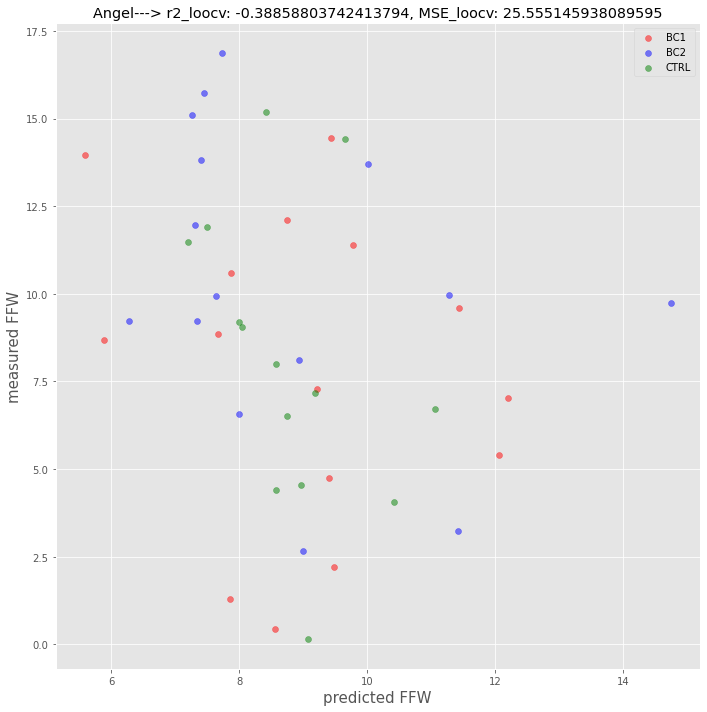

In [18]:
# Plot RMSE
#z = np.polyfit(y1, y_cv, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(y_cv[:15],y1[:15],c='red', alpha=0.5,label='BC1')
    ax.scatter(y_cv[15:30],y1[15:30],c='blue', alpha=0.5,label='BC2')
    ax.scatter(y_cv[30:],y1[30:],c='green', alpha=0.5,label='CTRL')
   # ax.plot(z[1]+z[0]*y1, y1, c='blue', linewidth=1)
    ax.set_xlabel('predicted FFW', fontsize=15)
    ax.set_ylabel('measured FFW', fontsize=15)
    ax.set_title('Angel---> r2_loocv: '+ str(score_loocv) +', MSE_loocv: '+ str(mse_loocv))
    ax.legend()

ax.grid(True)
fig.tight_layout()

plt.show()

In [19]:
labels = Kush_xls['TRT'].values
labels = np.reshape(labels,(len(labels),1))

In [20]:
result=np.concatenate([labels,np_true_y,y_cv,np_prediction_y],axis=1)
result=pd.DataFrame(data=result,columns=['TRT','ACT','noise_PRED','Feature_pred'])
result.head()

TRT     ACT noise_PRED Feature_pred
0  BC1  10.605    7.86741      9.17156
1  BC1  13.974    5.59098      8.53572
2  BC1    11.4    9.77371      9.50821
3  BC1   8.843     7.6767      8.67719
4  BC1   8.687    5.88223      9.35943

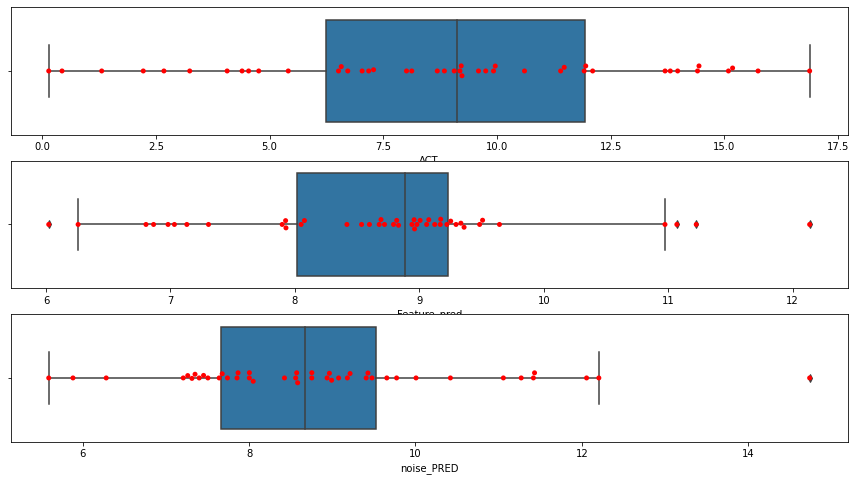

In [21]:
f, axes = plt.subplots(3, 1,figsize=(15,8))
sns.swarmplot(x=result["ACT"],color='red',ax=axes[0])
sns.boxplot(x=result["ACT"],ax=axes[0])

sns.swarmplot(x=result["Feature_pred"],color='red',ax=axes[1])
sns.boxplot(x=result["Feature_pred"],ax=axes[1])

sns.swarmplot(x=result["noise_PRED"],color='red',ax=axes[2])
sns.boxplot(x=result["noise_PRED"],ax=axes[2])

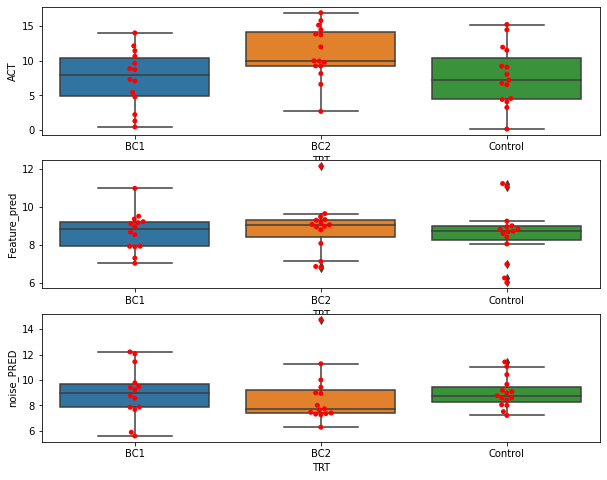

In [22]:
f, axes = plt.subplots(3, 1,figsize=(10,8))
sns.swarmplot(x="TRT",y= "ACT",color='red',data=result,ax=axes[0])
sns.boxplot(x="TRT",y= "ACT",data=result,ax=axes[0])


sns.swarmplot(x="TRT",y= "Feature_pred",color='red',data=result,ax=axes[1])
sns.boxplot(x="TRT",y= "Feature_pred",data=result,ax=axes[1])

sns.swarmplot(x="TRT",y= "noise_PRED",color='red',data=result,ax=axes[2])
sns.boxplot(x="TRT",y= "noise_PRED",data=result,ax=axes[2])


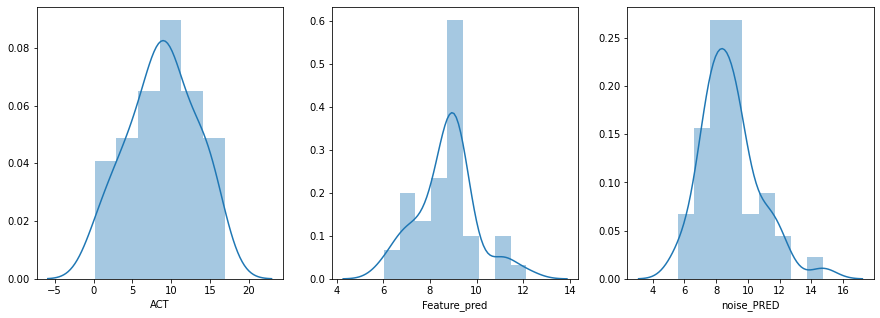

In [23]:
f, axes = plt.subplots(1, 3,figsize=(15,5))
sns.distplot(result["ACT"], ax=axes[0])
sns.distplot(result["Feature_pred"], ax=axes[1])
sns.distplot( result["noise_PRED"], ax=axes[2])